In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile

from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/MyDrive/OpenCV/Datasets/fer_images.zip"
zip_object = zipfile.ZipFile(file = path , mode = "r")
zip_object.extractall("./")
zip_object.close()

In [3]:
import tensorflow as tf

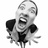

In [4]:
tf.keras.preprocessing.image.load_img("/content/fer2013/train/Angry/1003.jpg")

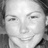

In [5]:
tf.keras.preprocessing.image.load_img("/content/fer2013/train/Happy/1.jpg")

# Train And Test Set

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
training_generator = ImageDataGenerator(rescale = 1. / 255, 
                                        horizontal_flip = True,
                                        rotation_range = 7,
                                        zoom_range = 0.2)

train_dataset = training_generator.flow_from_directory("/content/fer2013/train",
                                                       shuffle = True,
                                                       target_size = (48,48),
                                                       batch_size = 16,
                                                       class_mode = "categorical")

Found 28709 images belonging to 7 classes.


In [8]:
test_generator = ImageDataGenerator(rescale = 1. / 255)

test_dataset = test_generator.flow_from_directory("/content/fer2013/validation",
                                                   shuffle = False,
                                                   target_size = (48,48),
                                                   batch_size = 1,
                                                   class_mode = "categorical")

Found 3589 images belonging to 7 classes.


In [9]:
train_dataset.classes, train_dataset.class_indices

(array([0, 0, 0, ..., 6, 6, 6], dtype=int32),
 {'Angry': 0,
  'Disgust': 1,
  'Fear': 2,
  'Happy': 3,
  'Neutral': 4,
  'Sad': 5,
  'Surprise': 6})

In [10]:
np.unique(train_dataset.classes, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

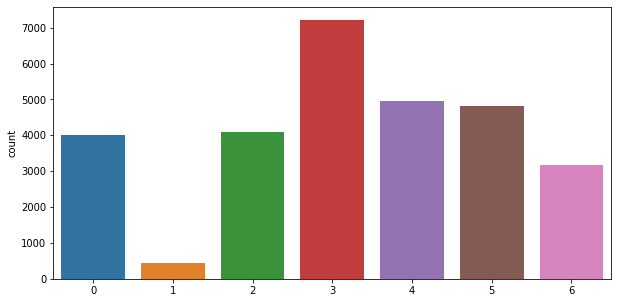

In [11]:
from warnings import filterwarnings
filterwarnings("ignore")

plt.figure(figsize = (10,5))
sns.countplot(train_dataset.classes)
plt.show()

# Building and Training The Neural Network

In [12]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Dense

In [ ]:
num_detectors = 32
num_classes = 7
width, height = 48 ,48
epochs = 70

model = Sequential()

model.add(Conv2D(filters = num_detectors, kernel_size= (3,3), activation = "relu", padding = "same", input_shape = (height,width,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = num_detectors, kernel_size= (3,3), activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same", input_shape = (width,height,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same", input_shape = (width,height,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 2*2*2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same", input_shape = (width,height,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*2*num_detectors, kernel_size= (3,3), activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

model.add(Flatten())

model.add(Dense(2*num_detectors, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.2))

model.add(Dense(2*num_detectors, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.2))

model.add(Dense(num_classes,activation = "softmax"))

model.summary()

In [15]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accurcay"])

### Çok uzun sürdüğü için hazır olarak yükleyelim

#history = model.fit(train_dataset , epochs = epochs, validation_data = test_dataset)

# Saving And Loading The Model

In [25]:
model_json_path = "/content/drive/MyDrive/OpenCV/Weights/network_emotions.json"
model_path = "/content/drive/MyDrive/OpenCV/Weights/weights_emotions.hdf5"

In [26]:
with open(model_json_path, "r") as file:
    model_read = file.read()
file.closed

True

In [27]:
model_read

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [28]:
from tensorflow.keras.models import model_from_json

In [29]:
load_model = model_from_json(model_read)
load_model.load_weights(model_path)
load_model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

load_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                      

# Evalutating The Neural Network

In [30]:
def history_graph(history, epochs):

    plt.figure(figsize = (10,6))

    plt.subplot(121)
    plt.plot(history.history["accuracy"],label = "Train")
    plt.plot(history.history["val_accuracy"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Accuracy Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.subplot(122)
    plt.plot(history.history["loss"],label = "Train")
    plt.plot(history.history["val_loss"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Loss Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.tight_layout()
    plt.show()

def confusion_graph(y_test,y_pred):

    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize = (10,5))
    sns.heatmap(cm, annot = True, fmt = "d", cbar = False, linewidth = 0.4, linecolor="white", annot_kws = {"size" : 20})
    plt.ylabel("Actual",fontsize = 15)
    plt.xlabel("Predicted",fontsize = 15)
    plt.title("Confusion Matrix Graph", fontsize = 15)
    plt.show()

In [31]:
load_model.evaluate(test_dataset)

3589/3589 [==============================] - 52s 14ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [33]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [34]:
y_pred = load_model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
y_pred[:10]

array([0, 0, 0, 0, 0, 1, 5, 0, 5, 5])

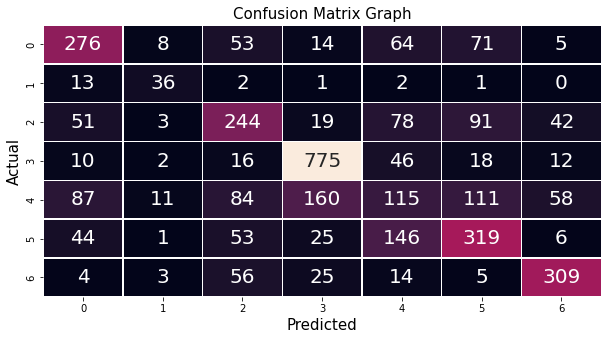

In [35]:
confusion_graph(test_dataset.classes, y_pred)

In [36]:
print(classification_report(test_dataset.classes , y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes , y_pred)))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589


Accuracy : 0.5778768459180831


# Classifying One Single Image

Shape :  (300, 400, 3)


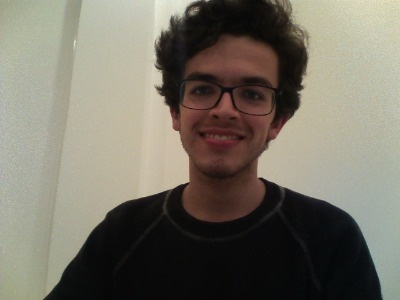

In [39]:
image = cv2.imread("/content/drive/MyDrive/OpenCV/Images/gabriel.png")
print("Shape : ", image.shape)
cv2_imshow(image)

Shape :  (128, 128, 3)


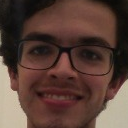

In [43]:
face_detector = cv2.CascadeClassifier("/content/drive/MyDrive/OpenCV/Cascades/haarcascade_frontalface_default.xml")
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

(x,y,w,h) = faces[0]

roi = image[y : y + h , x : w + x]
print("Shape : ", roi.shape)
cv2_imshow(roi)

Shape :  (48, 48, 3)


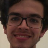

In [44]:
roi = cv2.resize(roi , (48,48))
print("Shape : ",roi.shape)
cv2_imshow(roi)

In [45]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [46]:
probs = load_model.predict(roi)
results = np.argmax(probs)
results 

0

In [54]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

# Classifying Multiple Images

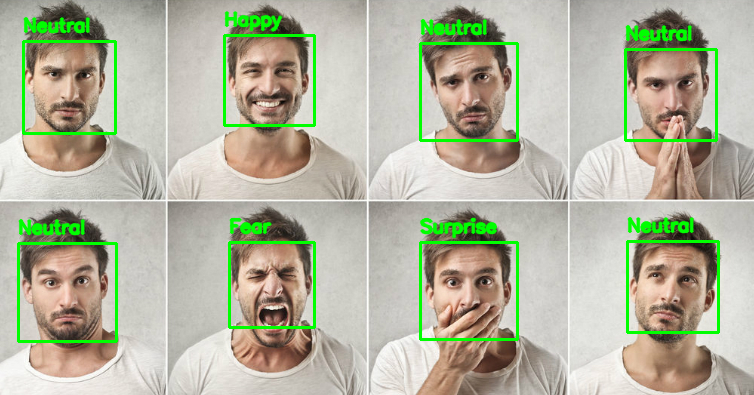

In [70]:
image = cv2.imread("/content/drive/MyDrive/OpenCV/Images/faces_emotions.png")
face_detector = cv2.CascadeClassifier("/content/drive/MyDrive/OpenCV/Cascades/haarcascade_frontalface_default.xml")
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

faces = face_detector.detectMultiScale(image)

for (x,y,w,h) in faces:

    roi = image[y : y+h , x : x +w]
    roi = cv2.resize(roi, (48,48))
    roi = roi / 255
    roi = np.expand_dims(roi, axis = 0)
    predictions = load_model.predict(roi)
    predictions = np.argmax(predictions)

    cv2.putText(image,emotions[predictions],(x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0),2,cv2.LINE_AA)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

cv2_imshow(image)

# Classifying Emotions In Videos

In [71]:
cap = cv2.VideoCapture("/content/drive/MyDrive/OpenCV/Videos/emotion_test01.mp4")
conn, frame = cap.read()

print(conn, frame.shape)

True (360, 640, 3)


In [72]:
save_path = "/content/emotion_test01_result.avi"
fourcc = cv2.VideoWriter_fourcc(*"XVID")
fps = 25
writer = cv2.VideoWriter(save_path, fourcc, fps , (frame.shape[1], frame.shape[0]))

In [73]:
face_detector = cv2.CascadeClassifier("/content/drive/MyDrive/OpenCV/Cascades/haarcascade_frontalface_default.xml")
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

while (cv2.waitKey(1) < 0):

    conn,frame = cap.read()

    if not conn:
        break
    
    faces = face_detector.detectMultiScale(frame, scaleFactor = 1.2, minNeighbors = 5, minSize = (30,30))

    if len(faces) > 0:
        for (x,y,w,h) in faces:
        
            cv2.rectangle(frame, (x,y), (x+w, y+h),(0,255,0),2)
            roi = frame[y : y+h, x : x + w]
            roi = cv2.resize(roi, (48,48))
            roi = roi / 255
            roi = np.expand_dims(roi, axis = 0)
            pred = load_model.predict(roi)

            if pred is not None:
                result = emotions[np.argmax(pred)]
                cv2.putText(frame, result, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1,cv2.LINE_AA)

    cv2_imshow(frame)
    writer.write(frame)

print("END")
writer.release()
cap.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.